# MIDST Challenge
Black-box MIA on single table given synthetic and holdout real data

# Import packages

In [39]:
import sys

sys.path.append("..")

from pathlib import Path

import numpy as np
import pandas as pd
from clover.generators.findiff_generator import FinDiffGenerator
from clover.utils.standard import save_pickle
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from src.attack import (
    blending,
    blending_plus,
    logan,
    soft_voting,
    stacking,
    stacking_plus,
    tablegan,
)
from src.data.process import generate_val_test
from src.utils import draw, standard, stats

# 1.Configuration

In [2]:
# Paths

data_dir = Path("/data8/projets/dev_synthetic_data/data/MIDST")
output_dir = Path("/data8/projets/dev_synthetic_data/output/MIDST")

# 2.Data

## 2.1 Population
Collect all the real data used to train TabDDPM

In [3]:
for i in range(1, 31):
    data_dir_ith = (
        data_dir / "tabddpm_black_box" / "train" / f"tabddpm_{i}" / "train_with_id.csv"
    )
    df_real_ith = pd.read_csv(data_dir_ith)

    if i == 1:
        df_real = df_real_ith
    else:
        df_real = pd.concat([df_real, df_real_ith])

In [4]:
df_real = df_real.drop_duplicates()

In [5]:
df_real.shape

(460972, 10)

In [6]:
df_real.head()

,trans_id,account_id,trans_date,trans_type,operation,amount,balance,k_symbol,bank,account
0,707363,2423,1377,2,1,1494.0,14377.4,5,6,35182595
1,867043,2951,1154,2,4,14.6,35891.2,6,0,0
2,417654,1416,282,2,4,37800.0,66826.9,1,0,0
3,619464,2114,2098,2,4,5400.0,17284.3,1,0,0
4,188479,638,2048,2,1,2487.0,28732.4,5,9,41244357


## 2.2 Real data
Take synthetic data generated by **tabddpm_1** as example

In [15]:
# Metadata of the dataset

metadata = {
    "continuous": ["trans_date", "amount", "balance", "account"],
    "categorical": ["trans_type", "operation", "k_symbol", "bank"],
    "variable_to_predict": "trans_type",
}

In [45]:
bounds = {
    "trans_type": {"categories": ["0", "1", "2"]},
    "operation": {"categories": ["0", "1", "2", "3", "4", "5"]},
    "k_symbol": {"categories": ["0", "1", "2", "3", "4", "5", "6", "7", "8"]},
    "bank": {
        "categories": [
            "0",
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "11",
            "12",
            "13",
        ]
    },
}

In [7]:
# Training data

real_dir_1st = (
    data_dir / "tabddpm_black_box" / "train" / "tabddpm_1" / "train_with_id.csv"
)
df_real_train = pd.read_csv(real_dir_1st)

In [8]:
df_real_train.shape

(20000, 10)

In [9]:
# Real control

df_real_control = df_real[~df_real["trans_id"].isin(df_real_train["trans_id"])]

In [10]:
# Sample a fraction

df_real_control = df_real_control.sample(
    n=len(df_real_train), replace=False, ignore_index=True, random_state=None
)

In [11]:
# Further split the control:
#   - One portion used as part of the validation set for ensemble model
#   - One portion used to construct the test set to evaluate the final model

df_real_control_val, df_real_control_test = train_test_split(
    df_real_control, test_size=0.5, random_state=None
)

In [12]:
# Drop ids

df_real_train = df_real_train.drop(columns=["trans_id", "account_id"])
df_real_control_val = df_real_control_val.drop(columns=["trans_id", "account_id"])
df_real_control_test = df_real_control_test.drop(columns=["trans_id", "account_id"])

In [17]:
# Type convertion

for col in metadata["categorical"]:
    df_real_train[col] = df_real_train[col].astype("object")
    df_real_control_val[col] = df_real_control_val[col].astype("object")
    df_real_control_test[col] = df_real_control_test[col].astype("object")

## 2.2 Synthetic data
We used **FinDiff** as example to generate 1st and 2nd generation synthetic data

In [18]:
# Train generator

gen = FinDiffGenerator(
    df=df_real_train,
    metadata=metadata,
    random_state=None,
    generator_filepath=None,
    learning_rate=1e-3,
    batch_size=256,
    diffusion_steps=500,
    epochs=500,
    mpl_layers=[1024, 1024, 1024, 1024],
    activation="lrelu",
    dim_t=64,
    cat_emb_dim=2,
    diff_beta_start_end=[1e-4, 0.02],
    scheduler="linear",
    epsilon=None,
)

gen.preprocess()
gen.fit(
    save_path=output_dir / "test" / "tabddpm_1" / "1st_gen"
)  # the path should exist

In [19]:
# Generate 1st geneartion synthetic data

df_synth_train = gen.sample(
    save_path=output_dir / "test" / "tabddpm_1" / "1st_gen",
    num_samples=len(df_real_train),
)

df_synth_test = gen.sample(
    save_path=output_dir / "test" / "tabddpm_1" / "1st_gen",
    num_samples=len(df_real_train) // 2,
)

In [20]:
# Generate 2nd generation synthetic data

gen_2nd = FinDiffGenerator(
    df=df_synth_train,
    metadata=metadata,
    random_state=None,
    generator_filepath=None,
    learning_rate=1e-3,
    batch_size=256,
    diffusion_steps=500,
    epochs=500,
    mpl_layers=[1024, 1024, 1024, 1024],
    activation="lrelu",
    dim_t=64,
    cat_emb_dim=2,
    diff_beta_start_end=[1e-4, 0.02],
    scheduler="linear",
    epsilon=None,
)

gen_2nd.preprocess()
gen_2nd.fit(
    save_path=output_dir / "test" / "tabddpm_1" / "2nd_gen"
)  # the path should exist

df_synth_2nd = gen.sample(
    save_path=output_dir / "test" / "tabddpm_1" / "2nd_gen",
    num_samples=len(df_real_train),
)

# 3.Membership inference attacks

## 3.1 Prepare inputs for different MIA models
Build train, validation and test sets
- Validation set is only used to train the meta classifier of the ensemble models
- We use the same test set to evaluate each model

In [21]:
cat_cols = [col for col in df_real_train.columns if col not in metadata["continuous"]]
cont_cols = [col for col in df_real_train.columns if col not in cat_cols]

In [22]:
# LOGAN

df_train_logan, y_train_logan = logan.prepare_data(
    df_synth_train=df_synth_train, df_synth_2nd=df_synth_2nd
)

In [23]:
# TableGAN

(
    df_train_tablegan_discriminator,
    y_train_tablegan_discriminator,
    df_train_tablegan_classifier,
    y_train_tablegan_classifier,
) = tablegan.prepare_data(
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_synth_2nd=df_synth_2nd,
    size_1st_gen_cla=len(df_synth_test),
    size_2nd_gen_dis=len(df_synth_train) - len(df_synth_test),
    seed=None,
)

In [24]:
# Validation data

df_val, y_val, _, _ = generate_val_test(
    df_real_train=df_real_train,
    df_real_control_val=df_real_control_val,
    df_real_control_test=df_real_control_test,
    seed=None,
)

## 3.2 Train and evalute MIA models
Attack models are evaluated with the provided test set

In [25]:
# Load the test set provided in tabddpm_1

df_test = pd.read_csv(
    data_dir / "tabddpm_black_box" / "train" / "tabddpm_1" / "challenge_with_id.csv"
)

y_test = pd.read_csv(
    data_dir / "tabddpm_black_box" / "train" / "tabddpm_1" / "challenge_label.csv"
)

In [26]:
# Drop id

df_test = df_test.drop(columns=["trans_id", "account_id"])

In [27]:
# Type convertion

for col in metadata["categorical"]:
    df_test[col] = df_test[col].astype("object")

y_test = y_test["is_train"].to_numpy()

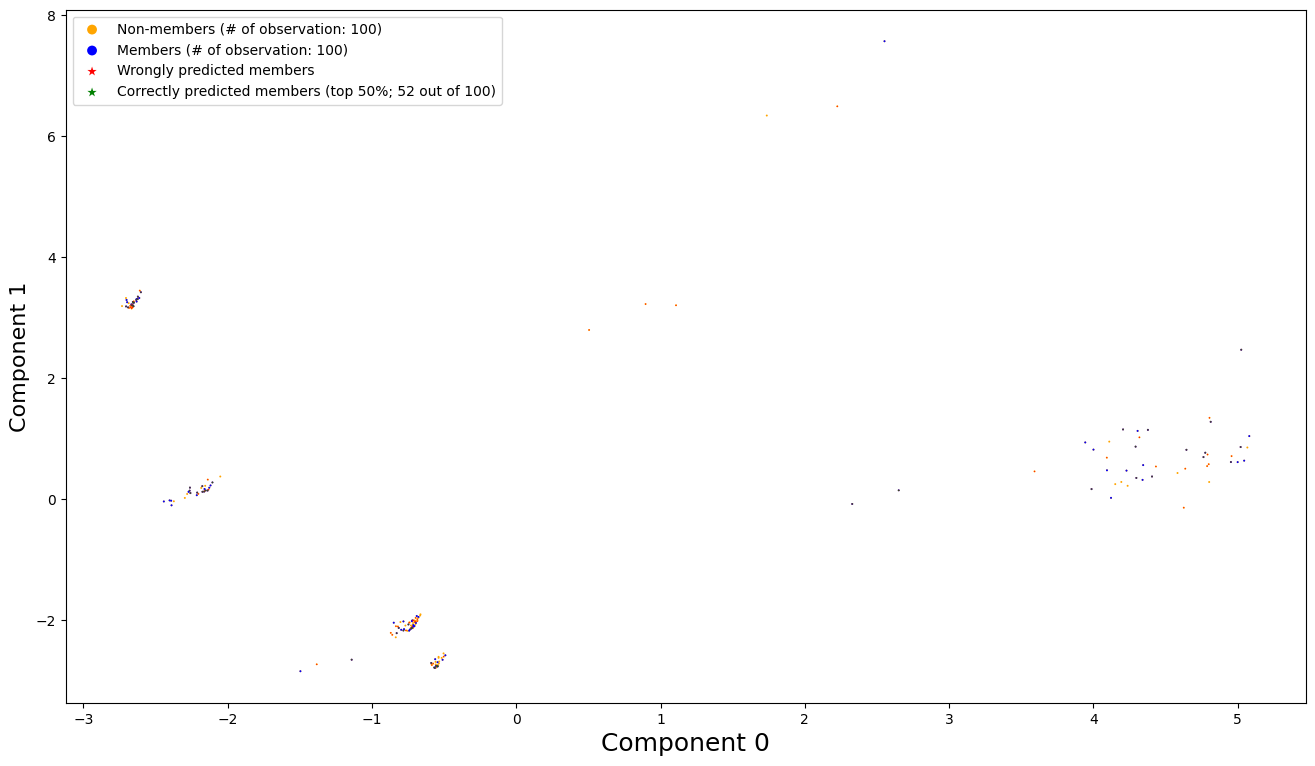

In [36]:
# LOGAN

pred_proba_logan = logan.fit_pred(
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
)[0]

tpr_at_fpr_logan = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_logan,
    max_fpr=0.1,
)

output_logan = output_dir / "test" / "tabddpm_1" / "logan"
standard.create_directory(output_logan)
np.savetxt(output_logan / "prediction.csv", pred_proba_logan, delimiter=",")

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_logan,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_logan / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

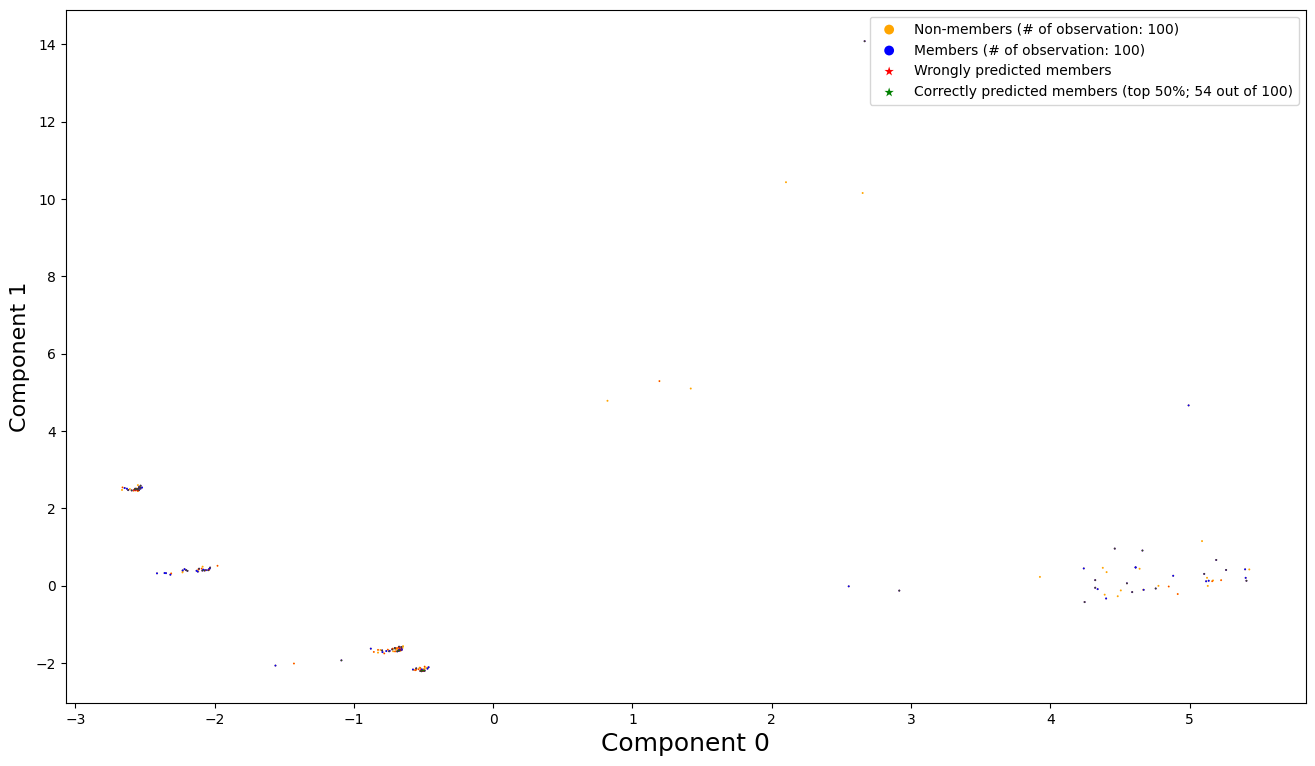

In [37]:
# TableGAN

pred_proba_tablegan = tablegan.fit_pred(
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
)[0]

tpr_at_fpr_tablegan = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_tablegan,
    max_fpr=0.1,
)

output_tablegan = output_dir / "test" / "tabddpm_1" / "tablegan"
standard.create_directory(output_tablegan)
np.savetxt(output_tablegan / "prediction.csv", pred_proba_tablegan, delimiter=",")

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_tablegan,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_tablegan / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

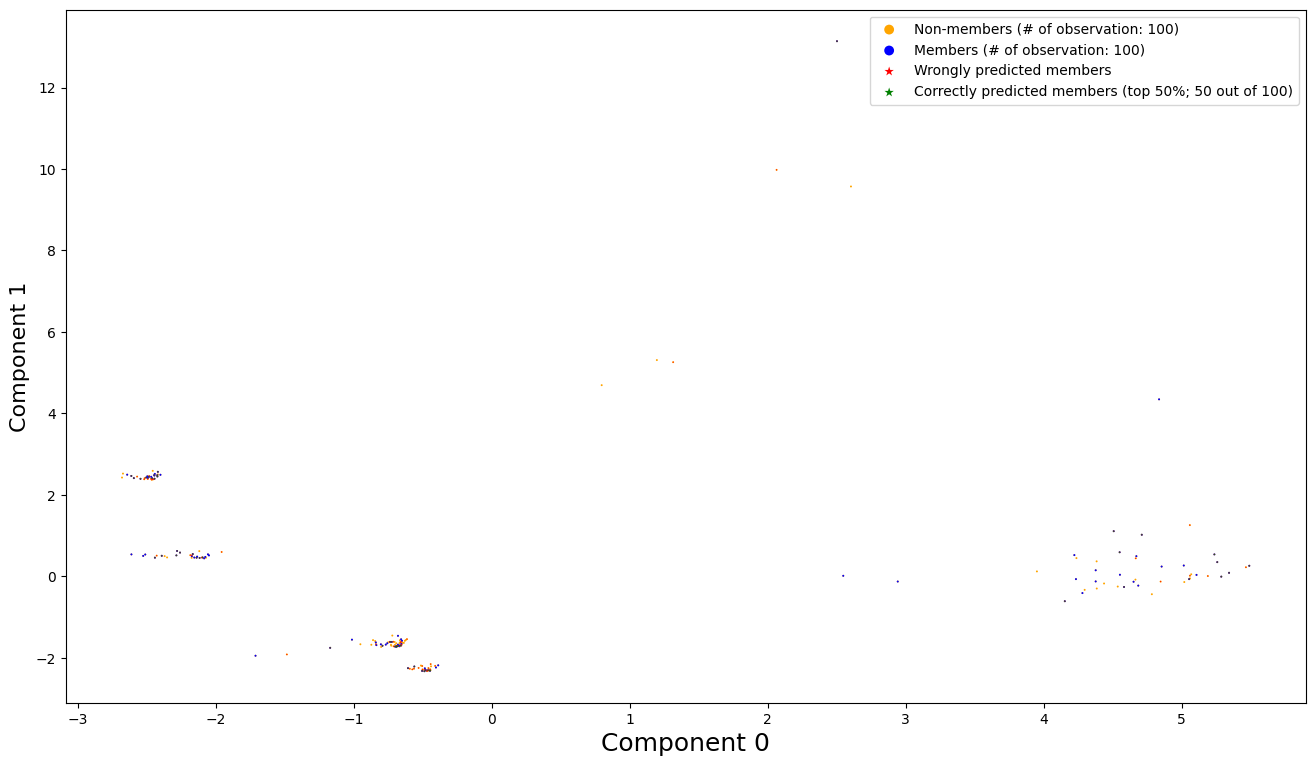

In [40]:
# Soft voting

pred_proba_soft_voting = soft_voting.fit_pred(
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
)[0]

tpr_at_fpr_soft_voting = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_soft_voting,
    max_fpr=0.1,
)

output_soft_voting = output_dir / "test" / "tabddpm_1" / "soft_voting"
standard.create_directory(output_soft_voting)
np.savetxt(output_soft_voting / "prediction.csv", pred_proba_soft_voting, delimiter=",")

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_soft_voting,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_soft_voting / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

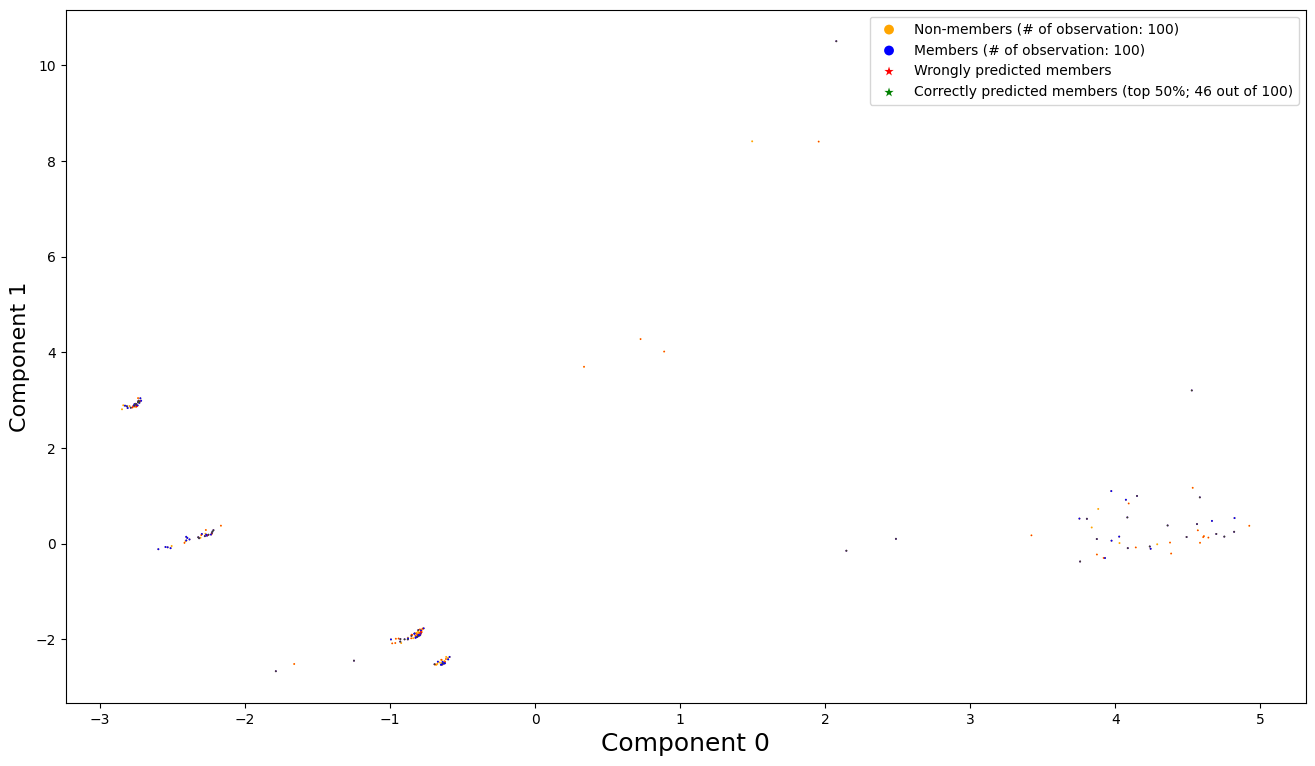

In [42]:
# Stacking

output_stacking = stacking.fit_pred(
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
    meta_classifier=None,
    df_val=df_val,
    y_val=y_val,
)

pred_proba_stacking = output_stacking["pred_proba"][0]
meta_classifier_stacking = output_stacking["meta_classifier"][0]

tpr_at_fpr_stacking = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_stacking,
    max_fpr=0.1,
)

output_stacking = output_dir / "test" / "tabddpm_1" / "stacking"
standard.create_directory(output_stacking)
np.savetxt(output_stacking / "prediction.csv", pred_proba_stacking, delimiter=",")
save_pickle(
        obj=meta_classifier_stacking,
        folderpath=output_stacking,
        filename="meta_classifier",
        date=False,
    )

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_stacking,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_stacking / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

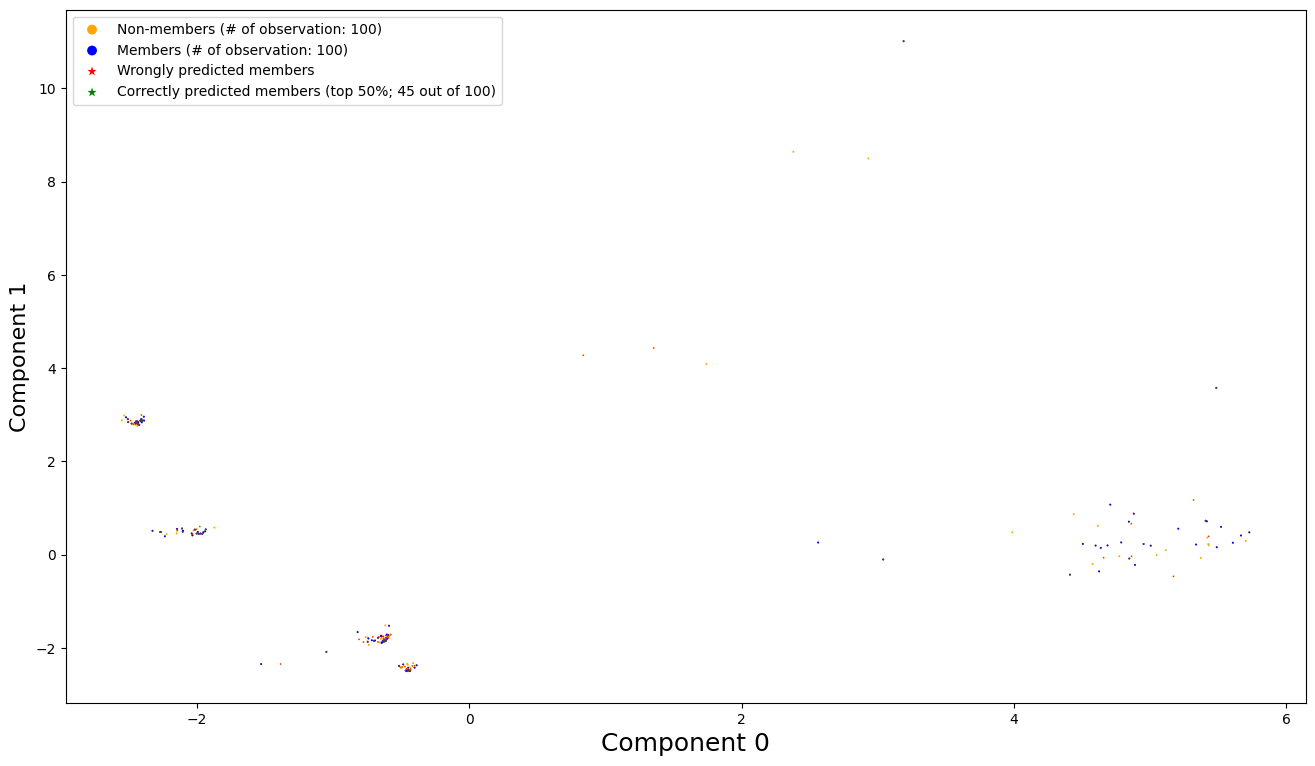

In [43]:
# Stacking+

output_stacking_plus = stacking_plus.fit_pred(
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
    meta_classifier=None,
    df_val=df_val,
    y_val=y_val,
)

pred_proba_stacking_plus = output_stacking_plus["pred_proba"][0]
meta_classifier_stacking_plus = output_stacking_plus["meta_classifier"][0]

tpr_at_fpr_stacking_plus = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_stacking_plus,
    max_fpr=0.1,
)

output_stacking_plus = output_dir / "test" / "tabddpm_1" / "stacking_plus"
standard.create_directory(output_stacking_plus)
np.savetxt(output_stacking_plus / "prediction.csv", pred_proba_stacking_plus, delimiter=",")
save_pickle(
        obj=meta_classifier_stacking_plus,
        folderpath=output_stacking_plus,
        filename="meta_classifier",
        date=False,
    )

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_stacking_plus,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_stacking_plus / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

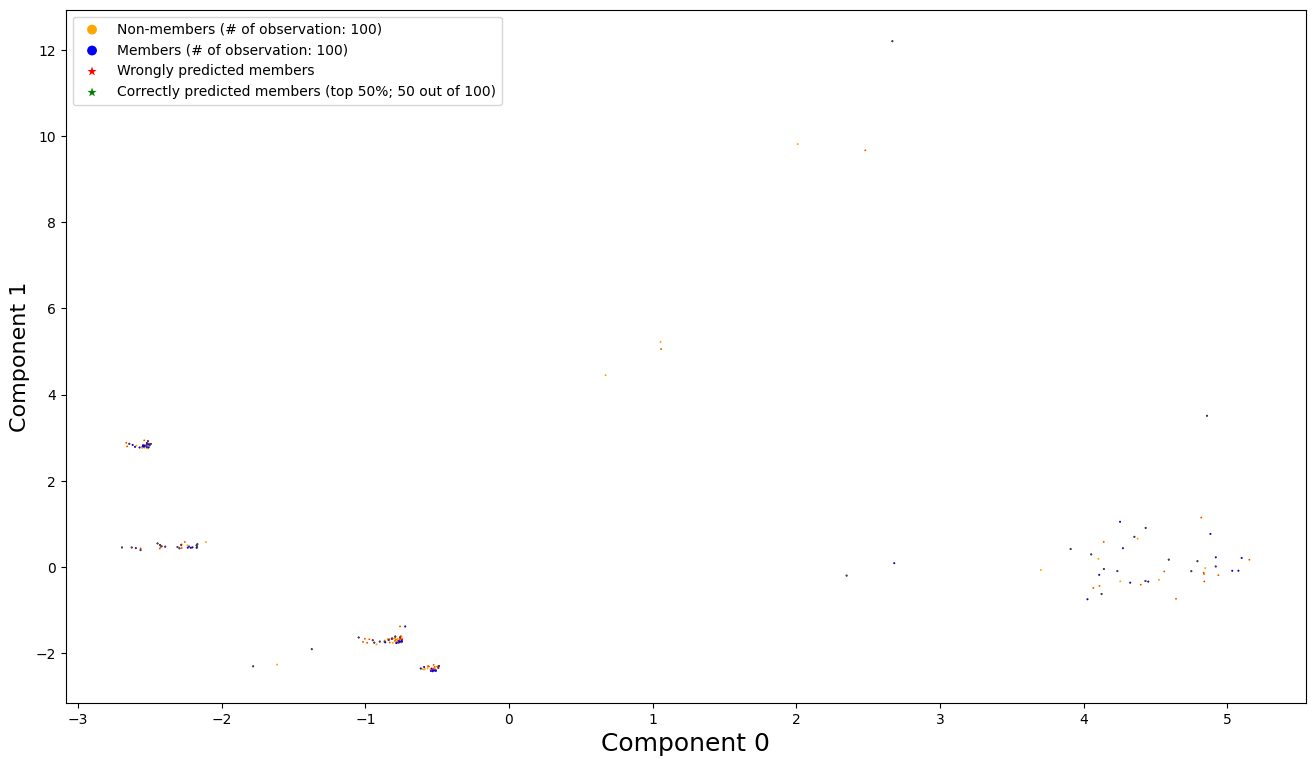

In [46]:
# Blending

output_blending = blending.fit_pred(
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
    meta_classifier=None,
    df_val=df_val,
    y_val=y_val,
    bounds=bounds,
)

pred_proba_blending = output_blending["pred_proba"][0]
meta_classifier_blending = output_blending["meta_classifier"][0]

tpr_at_fpr_blending = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_blending,
    max_fpr=0.1,
)

output_blending = output_dir / "test" / "tabddpm_1" / "blending"
standard.create_directory(output_blending)
np.savetxt(output_blending / "prediction.csv", pred_proba_blending, delimiter=",")
save_pickle(
        obj=meta_classifier_blending,
        folderpath=output_blending,
        filename="meta_classifier",
        date=False,
    )

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_blending,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_blending / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

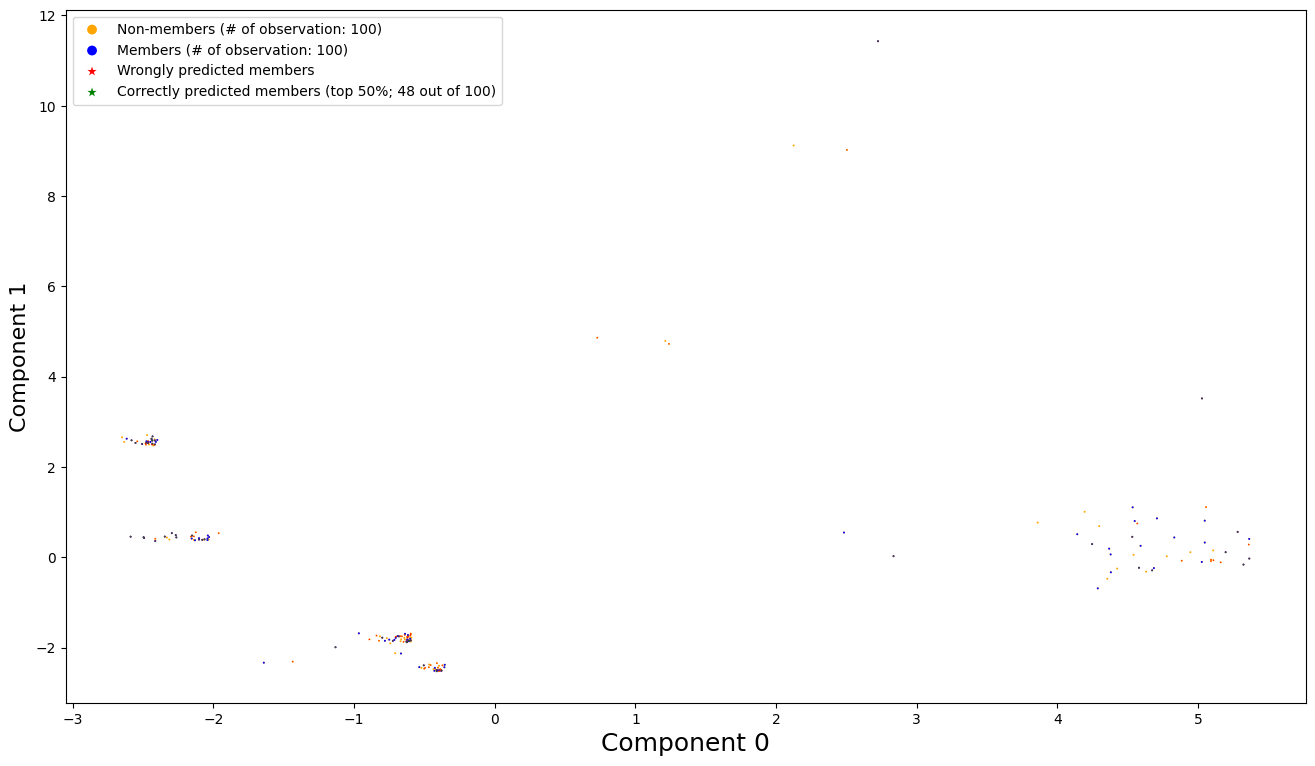

In [47]:
# Blending+

output_blending_plus = blending_plus.fit_pred(
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    cont_cols=metadata["continuous"],
    cat_cols=metadata["categorical"],
    iteration=1,
    meta_classifier=None,
    df_val=df_val,
    y_val=y_val,
    bounds=bounds,
)

pred_proba_blending_plus = output_blending_plus["pred_proba"][0]
meta_classifier_blending_plus = output_blending_plus["meta_classifier"][0]

tpr_at_fpr_blending_plus = stats.get_tpr_at_fpr(
    true_membership=y_test,
    predictions=pred_proba_blending_plus,
    max_fpr=0.1,
)

output_blending_plus = output_dir / "test" / "tabddpm_1" / "blending_plus"
standard.create_directory(output_blending_plus)
np.savetxt(output_blending_plus / "prediction.csv", pred_proba_blending_plus, delimiter=",")
save_pickle(
        obj=meta_classifier_blending_plus,
        folderpath=output_blending_plus,
        filename="meta_classifier",
        date=False,
    )

draw.plot_pred(
    df_test=df_test,
    y_pred_proba=pred_proba_blending_plus,
    cont_col=metadata["continuous"],
    n=50,
    save_path=output_blending_plus / "plot_pred.jpg",
    mode="eval",
    y_test=y_test,
    seed=None,
)

## 3.3 Attack results

In [49]:
print(f"LOGAN TPR at FPR==10%: {tpr_at_fpr_logan}")
print(f"TableGAN TPR at FPR==10%: {tpr_at_fpr_tablegan}")
print(f"Soft voting TPR at FPR==10%: {tpr_at_fpr_soft_voting}")
print(f"Stacking TPR at FPR==10%: {tpr_at_fpr_stacking}")
print(f"Stacking+ TPR at FPR==10%: {tpr_at_fpr_stacking_plus}")
print(f"Blending TPR at FPR==10%: {tpr_at_fpr_blending}")
print(f"Blending+ TPR at FPR==10%: {tpr_at_fpr_blending_plus}")

LOGAN TPR at FPR==10%: 0.09
TableGAN TPR at FPR==10%: 0.1
Soft voting TPR at FPR==10%: 0.16
Stacking TPR at FPR==10%: 0.06
Stacking+ TPR at FPR==10%: 0.11
Blending TPR at FPR==10%: 0.1
Blending+ TPR at FPR==10%: 0.12
